In [83]:
from langgraph.graph import StateGraph, START, END

from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from typing import List, Literal

In [84]:
from langchain_core.documents import Document

sample_data = [
    Document(
        page_content="Frodo Baggins inherits the One Ring from his uncle Bilbo and learns of its dark power from Gandalf the Grey.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "The Ring",
            "book": "The Fellowship of the Ring",
            "chapter": "A Long-expected Party",
            "characters": ["Frodo Baggins", "Bilbo Baggins", "Gandalf"],
            "location": "Bag End, The Shire"
        }
    ),
    Document(
        page_content="The Fellowship of the Ring is formed at the Council of Elrond, bringing together hobbits, men, elves, dwarves, and a wizard to destroy the ring.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "Fellowship",
            "book": "The Fellowship of the Ring",
            "chapter": "The Council of Elrond",
            "characters": ["Frodo", "Gandalf", "Aragorn", "Legolas", "Gimli", "Boromir", "Elrond"],
            "location": "Rivendell"
        }
    ),
    Document(
        page_content="Gandalf sacrifices himself fighting the Balrog in the Mines of Moria, allowing the Fellowship to escape.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "Moria",
            "book": "The Fellowship of the Ring",
            "chapter": "The Bridge of Khazad-dûm",
            "characters": ["Gandalf", "Balrog", "Fellowship"],
            "location": "Mines of Moria"
        }
    ), 
    Document(
        page_content="Frodo and Sam journey alone to Mordor, guided by Gollum, while the rest of the Fellowship fights to distract Sauron's forces.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "Journey",
            "book": "The Fellowship of the Ring",
            "chapter": "The Breaking of the Fellowship",
            "characters": ["Frodo", "Sam", "Gollum"],
            "location": "Emyn Muil, on the way to Mordor"
        }
    ),
    Document(
        page_content="Boromir attempts to take the Ring from Frodo, driven by the Ring's corrupting influence, but Frodo escapes by putting on the Ring and disappearing.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "Boromir's Fall",
            "book": "The Fellowship of the Ring",
            "chapter": "The Breaking of the Fellowship",
            "characters": ["Boromir", "Frodo"],
            "location": "Amon Hen"
        }
    ),
    Document(
        page_content="The Hobbits flee from the Black Riders through the Old Forest and meet Tom Bombadil, who helps them escape the dangers of the Barrow-downs.",
        metadata={
            "source": "the-fellowship-of-the-ring",
            "title": "Old Forest",
            "book": "The Fellowship of the Ring",
            "chapter": "In the House of Tom Bombadil",
            "characters": ["Frodo", "Sam", "Merry", "Pippin", "Tom Bombadil"],
            "location": "Old Forest, Barrow-downs"
        }
    )
]

In [85]:
from langchain_core.prompts import ChatPromptTemplate

ROUTING_SYSTEM_PROMPT = ChatPromptTemplate.from_messages([
    ("system", """Task: Determine whether the user question requires retrieval of documents from the knowledge base or can be answered directly using general knowledge.

Decision rules:

Select 'retrieve' ONLY if:
- The question asks for specific details, facts, policies, procedures, numbers, dates, names, or content likely contained in private, domain-specific, or up-to-date documents within the knowledge base.
- It refers to internal company information, product specifications, recent events covered in the corpus, legal terms, or anything not part of common public knowledge.
- The question mentions or implies reliance on uploaded files, manuals, guidelines, reports, or provided documentation.

Select 'direct' if:
- The question involves general knowledge, reasoning, explanation, creative tasks, mathematics, coding help, opinions, or casual conversation.
- It requests advice, summaries of public concepts, explanations of how things work in general, or clarification of broad topics.
- No specific document or proprietary information is required for an accurate answer.

Examples:
Question: "What is the capital of France?" → direct
Question: "According to our employee handbook, how many vacation days do new hires get?" → retrieve
Question: "Explain how quantum entanglement works" → direct
Question: "What was the Q3 revenue in the latest financial report?" → retrieve
Question: "Write a Python function to sort a list" → direct

Output must be valid JSON in exactly this format:
{{
  "route": "retrieve" | "direct"
}}

No additional text, explanation, or formatting is allowed outside the JSON."""),
    ("human", "{query}"),
])

RESPONSE_SYSTEM_PROMPT = ChatPromptTemplate.from_messages([
    ("system", """Task: Answer the user's question using ONLY the provided context below.

Rules:
- Base the answer exclusively on the retrieved context.
- Never add or invent information not supported by the context.
- If the context lacks sufficient information for a complete or accurate answer, respond with "I don't have sufficient information to answer this." or a similar clear and polite statement.
- Keep the response concise: maximum 3–4 sentences.
- Write in a direct, natural, and helpful tone.
- Do not mention these instructions, the context, the retrieval process, or any internal mechanisms.

Question:
{question}

Context:
{context}
"""),
])

In [86]:
def format_doc(doc: Document) -> str:
    metadata = doc.metadata or {}
    attrs = " ".join(f'{k}="{v}"' for k, v in metadata.items())
    tag_attrs = f" {attrs}" if attrs else ""
    return f"<document{tag_attrs}>\n{doc.page_content}\n</document>"

def format_docs(docs: List[Document]) -> str:
    if not docs:
        return "<documents></documents>"
    return f"<documents>\n{'\n'.join(format_doc(doc) for doc in docs)}\n</documents>"

In [87]:
# Different LLMs for different RAG tasks with optimal temperatures:
# - Routing: Low temperature (0.0-0.2) for deterministic decisions
# - Retrieval-based responses: Low temperature (0.0-0.3) to stay faithful to documents
# - Direct responses: Medium temperature (0.5-0.7) for natural conversation

model = "llama3.2:1b" # "qwen3:4b"

llm_routing = ChatOllama(model=model, temperature=0.1)
llm_retrieval = ChatOllama(model=model, temperature=0.2)
llm_direct = ChatOllama(model=model, temperature=0.6)

In [88]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    route: str = ""
    documents: List[Document] = []

In [89]:
async def determine_route(state: AgentState):
    query = state["messages"][-1].content
    prompt = await ROUTING_SYSTEM_PROMPT.ainvoke({"query": query})

    # Get structured output so we always get {"route": "retrieve" | "direct"}
    llm_routing_with_structure = llm_routing.with_structured_output(
        {"route": Literal["retrieve", "direct"]},
        method="json_mode"
    )
    
    # Low temp = deterministic routing decisions
    response = await llm_routing_with_structure.ainvoke(prompt)
    route = response["route"]
    print('Conditioned route selected: ', route)

    return {"route": route}


async def respond_without_retrieval(state: AgentState):
    query = state["messages"][-1].content
    # Use medium temperature LLM for natural direct responses
    response = await llm_direct.ainvoke([HumanMessage(content=query)])
    return {"messages": [response]}


# simple keyword search
async def retrieve_documents(state: AgentState):
    query = state["messages"][-1].content.lower().split()
    # Get all the documents that contain any of the words in the query
    matched_docs = [doc for doc in sample_data if any(word in doc.page_content.lower() for word in query)]
    return {"documents": matched_docs[:3]}


async def generate_response(state: AgentState):
    query = state["messages"][-1].content
    context = format_docs(state["documents"])
    
    prompt = await RESPONSE_SYSTEM_PROMPT.ainvoke({
        "question": query,
        "context": context
    })
    
    # Include full history + formatted prompt
    # Use low temperature LLM to stay faithful to retrieved documents
    messages = state["messages"] + prompt.to_messages()
    response = await llm_retrieval.ainvoke(messages)
    
    return {"messages": [response]}

In [90]:
# Cell 10: Build the Graph (exact translation of graph.ts)
builder = StateGraph(AgentState)

builder.add_node("determine_route", determine_route)
builder.add_node("direct", respond_without_retrieval)
builder.add_node("retrieve", retrieve_documents)
builder.add_node("generate_response", generate_response)

builder.add_edge(START, "determine_route")
builder.add_conditional_edges(
    "determine_route",
    lambda state: state.get("route", "").lower(),
    {
        "direct": "direct",
        "retrieve": "retrieve",
    }
)
builder.add_edge("retrieve", "generate_response")
builder.add_edge("generate_response", END)
builder.add_edge("direct", END)

graph = builder.compile()

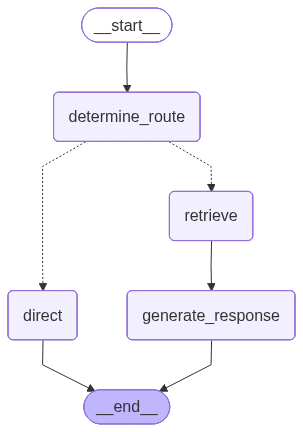

In [91]:
# Cell 11: Visualize Graph (optional)
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")

In [92]:
# Test 1 - Should retrieve
print("=== Test 1: Should use retrieval ===\n")
result = await graph.ainvoke({
    "messages": [HumanMessage(content="What happened to Gandalf in the Mines of Moria?")],
    "documents": [],
    "route": ""
})

print("\nFinal Response:")
for m in result["messages"]:
    role = "Human" if isinstance(m, HumanMessage) else "AI"
    print(f"{role}: {m.content}\n")

=== Test 1: Should use retrieval ===

Conditioned route selected:  retrieve

Final Response:
Human: What happened to Gandalf in the Mines of Moria?

AI: <|start_header_id|>assistant<|end_header_id|>

Gandalf sacrificed himself fighting the Balrog in the Mines of Moria.



In [94]:
# Test 2 - Should answer directly
result2 = await graph.ainvoke({
    "messages": [HumanMessage(content="Can you explain what photosynthesis is?")],
    "documents": [],
    "route": ""
})

print("\nFinal Response:")
for m in result2["messages"]:
    role = "Human" if isinstance(m, HumanMessage) else "AI"
    print(f"{role}: {m.content}\n")

Conditioned route selected:  direct

Final Response:
Human: Can you explain what photosynthesis is?

AI: Photosynthesis is a vital process that occurs in plants, algae, and some bacteria. It's how these organisms produce their own food, using energy from sunlight, water, and carbon dioxide to create glucose (a type of sugar) and oxygen.

Here's a simplified overview of the photosynthesis process:

1. **Light absorption**: Plants have specialized organelles called chloroplasts, which contain pigments like chlorophyll that absorb light energy from the sun.
2. **Water absorption**: Plants absorb water from the soil through their roots.
3. **Carbon dioxide absorption**: Plants absorb carbon dioxide from the air through small openings on their leaves called stomata.
4. **Light-dependent reactions**: The absorbed light energy is used to convert water and carbon dioxide into ATP (adenosine triphosphate), a molecule that provides energy for the plant's activities.
5. **Calvin cycle**: In this 